In [ ]:
!wget https://perso.esiee.fr/~gueurett/LV_Research/dataset_audio.zip
!unzip dataset_audio.zip

--2022-06-20 21:21:45--  https://perso.esiee.fr/~gueurett/dataset_audio.zip
Resolving perso.esiee.fr (perso.esiee.fr)... 147.215.150.8
Connecting to perso.esiee.fr (perso.esiee.fr)|147.215.150.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156353364 (149M) [application/zip]
Saving to: ‘dataset_audio.zip’

dataset_audio.zip   100%[===================>] 149.11M  24.9MB/s    in 6.6s    

2022-06-20 21:21:53 (22.5 MB/s) - ‘dataset_audio.zip’ saved [156353364/156353364]

Archive:  dataset_audio.zip
   creating: dataset_audio/
  inflating: dataset_audio/I0014.wav  
  inflating: dataset_audio/I0044.wav  
  inflating: dataset_audio/I0094.wav  
  inflating: dataset_audio/I0114.wav  
  inflating: dataset_audio/I0164.wav  
  inflating: dataset_audio/I0194.wav  
  inflating: dataset_audio/I0264.wav  
  inflating: dataset_audio/I0304.wav  
  inflating: dataset_audio/I0354.wav  
  inflating: dataset_audio/I0374.wav  
  inflating: dataset_audio/I0384.wav  
  inflating: da

In [ ]:
# if wget desn't work (happens sometimes I believe it's because my school servers are blocking the access), import the dataset manualy and unzip on this block
!unzip dataset_audio.zip

Archive:  dataset_audio.zip
   creating: dataset_audio/
  inflating: dataset_audio/I0014.wav  
  inflating: dataset_audio/I0044.wav  
  inflating: dataset_audio/I0094.wav  
  inflating: dataset_audio/I0114.wav  
  inflating: dataset_audio/I0164.wav  
  inflating: dataset_audio/I0194.wav  
  inflating: dataset_audio/I0264.wav  
  inflating: dataset_audio/I0304.wav  
  inflating: dataset_audio/I0354.wav  
  inflating: dataset_audio/I0374.wav  
  inflating: dataset_audio/I0384.wav  
  inflating: dataset_audio/I0404.wav  
  inflating: dataset_audio/I0424.wav  
  inflating: dataset_audio/I0474.wav  
  inflating: dataset_audio/I0534.wav  
  inflating: dataset_audio/I0614.wav  
  inflating: dataset_audio/I0624.wav  
  inflating: dataset_audio/I0724.wav  
  inflating: dataset_audio/I0734.wav  
  inflating: dataset_audio/I0744.wav  
  inflating: dataset_audio/I0754.wav  
  inflating: dataset_audio/I0764.wav  
  inflating: dataset_audio/I0774.wav  
  inflating: dataset_audio/I0784.wav  
  inflat

In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import initializers
from pydub import AudioSegment
from sklearn import preprocessing
from scipy.io.wavfile import read
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import AdaBoostClassifier
#from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Input, Flatten, Embedding, multiply, Dropout, Conv2D
#from scipy.signal import stft

In [ ]:
def delete_excess(data):

  return data[:length_audio]

In [ ]:
def add_average(data):

  result = np.zeros(shape=(length_audio,))
  end = data.shape[0]
  #print("initial shape:", data.shape)
  #print(data[end-25:,0])
  #print(data[end-25:,1])
  mean = np.mean(data[end-25:])
  result[:end] = data
  result[end:] = mean
  #print("mean0:", mean0)
  #print("mean1:", mean1)
  #print("result[end:]", result[end-25:])
  #print("final shape:", result.shape)
  return result

In [ ]:
# data = a numpy array containing the signal to be processed
# fs = a scalar which is the sampling frequency of the data

def get_stft(data, fs):

  overlap_fac = 0.5
  fft_size = 1000
  
  hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
  pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
  total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
  t_max = len(data) / np.float32(fs)
  
  window = np.hanning(fft_size)  # our half cosine window
  inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size
  
  proc = np.concatenate((data, np.zeros(pad_end_size)))              # the data to process
  Zxx = np.empty((total_segments, fft_size), dtype=np.float32)    # space to hold the result
  
  for i in range(total_segments):                      # for each segment
    current_hop = hop_size * i                        # figure out the current segment offset
    segment = proc[current_hop:current_hop+fft_size]  # get the current segment
    windowed = segment * window                       # multiply by the half cosine function
    padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
    spectrum = np.fft.fft(padded) / fft_size          # take the Fourier Transform and scale by the number of samples
    autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
    Zxx[i, :] = autopower[:fft_size]               # append to the results array
  
  Zxx = 20*np.log10(Zxx)          # scale to db
  Zxx = np.clip(Zxx, -40, 200)    # clip values
  
  return Zxx

In [ ]:
def show_image(image):
  img = plt.imshow(image, origin='lower', cmap='jet', interpolation='nearest', aspect='auto')
  plt.show()

In [ ]:
directory = "./dataset_audio/"
file_name = "I0474.wav"
path = directory + file_name

print(path)

rate, data = read(path)

print("rate = ", rate)
print("data.shape = ", data.shape)

length = data.shape[0] / rate
print("length(s): ", length, "s")
length_audio = data.shape[0]
print("length of unique audio:", length_audio)
nb_channels = data.shape[1]
print("number of channels: ", nb_channels)

./dataset_audio/I0474.wav
rate =  44100
data.shape =  (176400, 2)
length(s):  4.0 s
length of unique audio: 176400
number of channels:  2


(176400, 2)


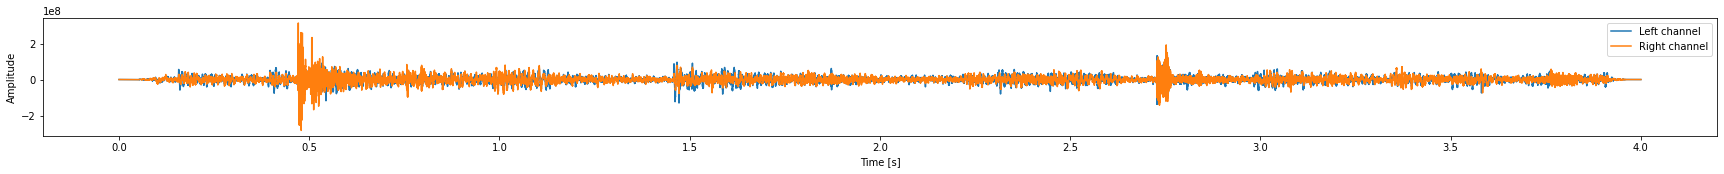

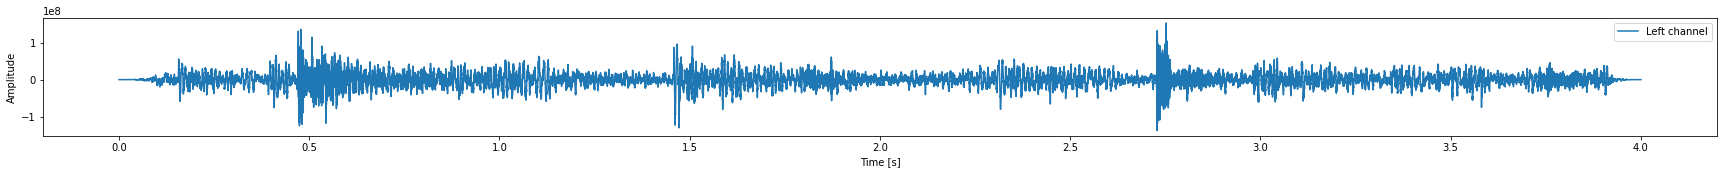

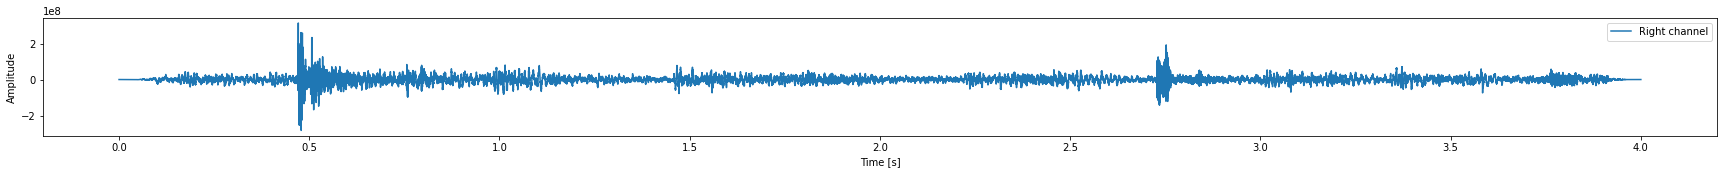

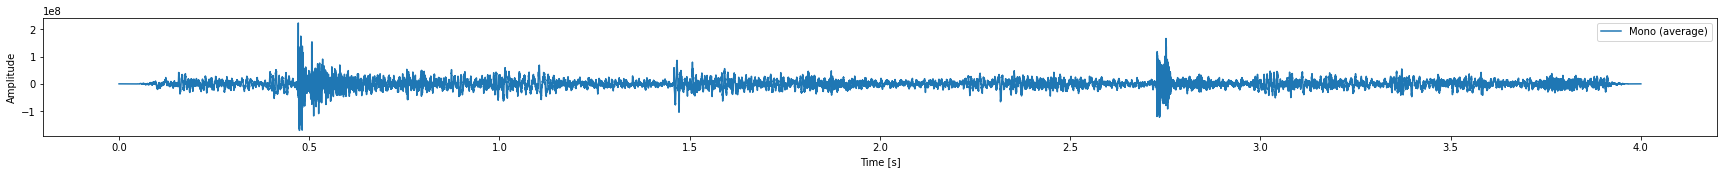

In [ ]:
time = np.linspace(0., length, data.shape[0])

print(data.shape)

fig = plt.figure(figsize=(30, 10))
plt.subplot(4,1,1)
plt.plot(time, data[:, 0], label="Left channel")
plt.plot(time, data[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

fig = plt.figure(figsize=(30, 10))
plt.subplot(4,1,2)
plt.plot(time, data[:, 0], label="Left channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

fig = plt.figure(figsize=(30, 10))
plt.subplot(4,1,3)
plt.plot(time, data[:, 1], label="Right channel")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

fig = plt.figure(figsize=(30, 10))
plt.subplot(4,1,4)
plt.plot(time, np.mean(data,axis=1), label="Mono (average)")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
number_file = 0
for file_name in os.listdir(directory):
  number_file += 1
print("number of files:", number_file)

dataset = np.zeros(shape=(number_file, length_audio))
print("dataset.shape:", dataset.shape)
print("first instance:",dataset[0].shape)

number of files: 200
dataset.shape: (200, 176400)
first instance: (176400,)


In [ ]:
# creating the dataset and labels

labels = np.zeros(shape=(number_file,))

# reshaping the data if not exactly 4s
for index, filename in enumerate(os.listdir(directory)):
  if filename[0] == 'I': labels[index] = 1
  path = directory + filename
  rate, data = read(path)
  data = np.mean(data,axis=1)
  dim = data.shape
  if dim != (length_audio, nb_channels):
    if dim[0] > length_audio:
      result = delete_excess(data)
    else:
      result = add_average(data)
    dataset[index] = result
  else:
    dataset[index] = data

print("Shape of the dataset: ", dataset.shape)
print("Shape of the labels : ", labels.shape)

Shape of the dataset:  (200, 176400)
Shape of the labels :  (200,)


argument:  99
filename:  O3394.wav
label   :  0.0
./dataset_audio/O3394.wav


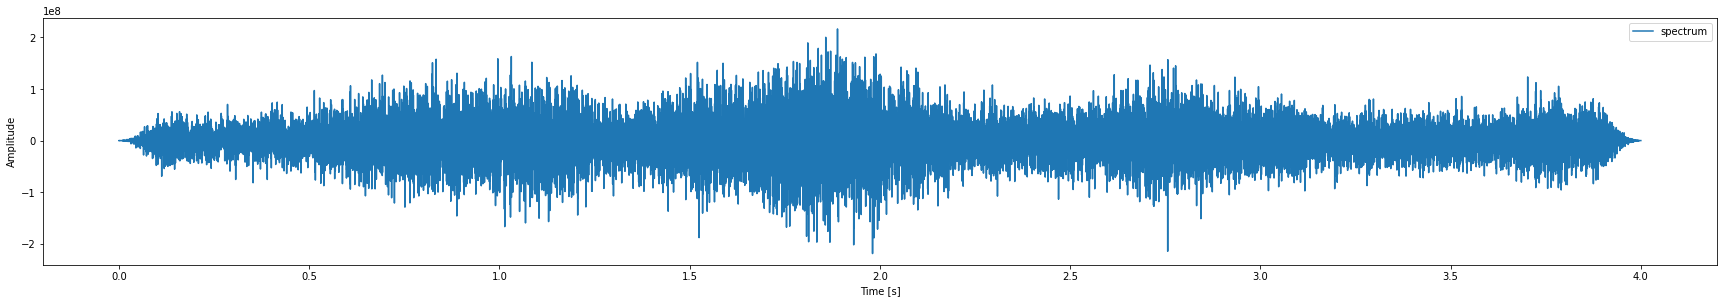

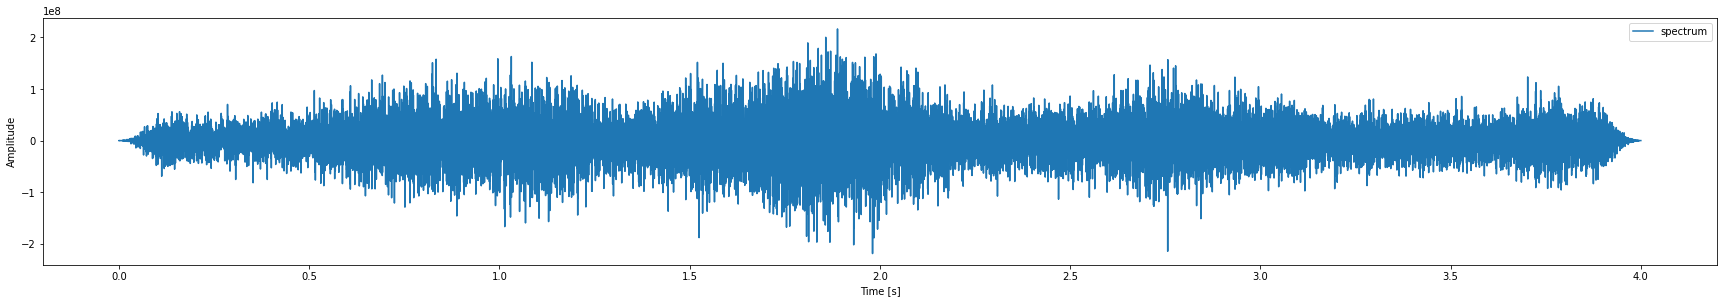

In [ ]:
# try to print a random spectrum
ran = np.random.randint(0, dataset.shape[0])
print("argument: ", ran)

for index, filename in enumerate(os.listdir(directory)):
  if index == ran:
    print("filename: ", filename)
    print("label   : ", labels[index])
    path = directory + filename

    print(path)

    rate, data = read(path)


    length = data.shape[0] / rate
    length_audio = data.shape[0]
    nb_channels = data.shape[1]

    data = np.mean(data, axis=1)

    time = np.linspace(0., length, data.shape[0])

    fig = plt.figure(figsize=(30, 10))
    plt.subplot(2,1,1)
    plt.plot(time, data[:], label='spectrum')
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()
    fig = plt.figure(figsize=(30, 10))
    plt.subplot(2,1,2)
    plt.plot(time, dataset[ran], label='spectrum')
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()

In [ ]:
print("----------------------------------")
print("| dataset.shape: ", dataset.shape)
print("----------------------------------")
print("| labels.shape : ", labels.shape)
print("----------------------------------")

----------------------------------
| dataset.shape:  (200, 176400)
----------------------------------
| labels.shape :  (200,)
----------------------------------


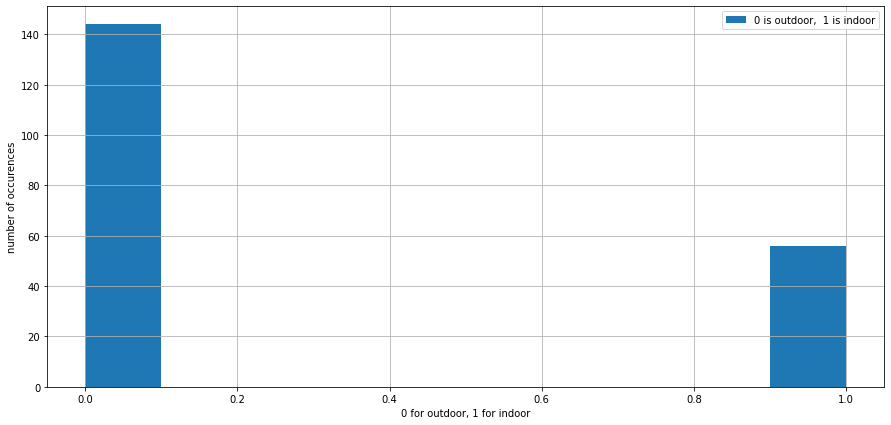

In [ ]:
plt.figure(figsize=(15,7))
plt.hist(labels, label='0 is outdoor,  1 is indoor')
plt.xlabel('0 for outdoor, 1 for indoor')
plt.ylabel('number of occurences')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# transformation to image with a fourrier transform

random_data = dataset[ np.random.randint(0,200,size=(10,))]
print("data.shape:", random_data.shape)

data.shape: (10, 176400)


Shape of Zxx:  (353, 1000) 



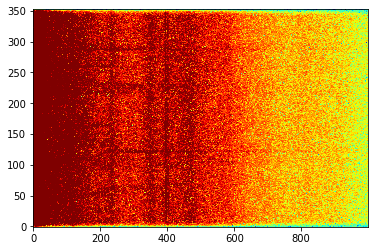

Shape of Zxx:  (353, 1000) 



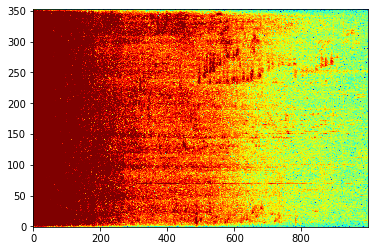

Shape of Zxx:  (353, 1000) 



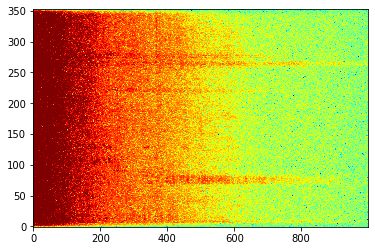

Shape of Zxx:  (353, 1000) 



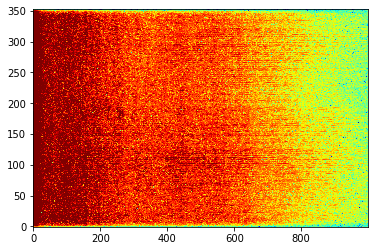

Shape of Zxx:  (353, 1000) 



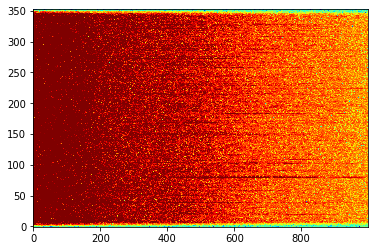

Shape of Zxx:  (353, 1000) 



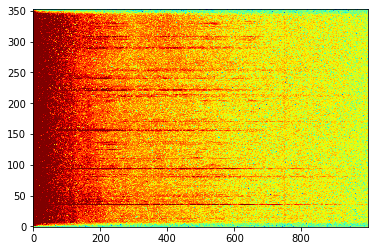

Shape of Zxx:  (353, 1000) 



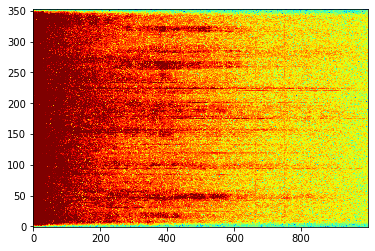

Shape of Zxx:  (353, 1000) 



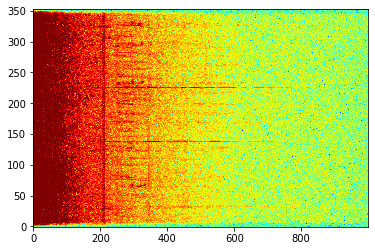

Shape of Zxx:  (353, 1000) 



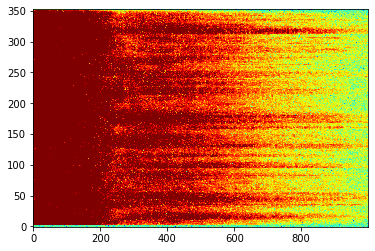

Shape of Zxx:  (353, 1000) 



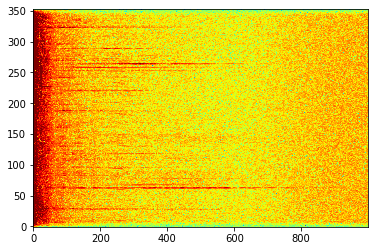

In [ ]:
for data in random_data:
  Zxx = get_stft(data, rate)
  print("Shape of Zxx: ", Zxx.shape, "\n")
  show_image(Zxx)
image_shape = Zxx.shape

In [ ]:
dataset_images = np.zeros(shape=(number_file, image_shape[0], image_shape[1]))
print("shape of the dataset: ", dataset.shape)
print("\nWe will now transfrm the dataset to images via Short-time-fourier-transform:")

for index, spectrum in enumerate(dataset):
  if index%(number_file/10) == 0:
    print(index/2, "%  ", sep='', end='')
  dataset_images[index] = get_stft(spectrum, rate)
print("100%   -  Done")
dataset_images = np.expand_dims(dataset_images, axis=3)
print("\nshape of the dataset: ", dataset_images.shape)


shape of the dataset:  (200, 176400)

We will now transfrm the dataset to images via Short-time-fourier-transform:
0.0%  10.0%  20.0%  30.0%  40.0%  50.0%  60.0%  70.0%  80.0%  90.0%  100%   -  Done

shape of the dataset:  (200, 353, 1000, 1)


In [ ]:
print(dataset_images.shape)
print(labels.shape)

(200, 353, 1000, 1)
(200,)


---

---

# **CNN**

In [ ]:
def get_model():

  model = tf.keras.Sequential()

  model.add(layers.Conv2D(32, (5,5), strides=(2,4), padding='same', input_shape=(353, 1000, 1)))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(512, (5,5), strides=(4,4), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(1024, (5,5), strides=(2,2), padding='same'))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())

  model.add(layers.Dense(2048))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(1, activation='sigmoid'))

  model.summary()
  return model

In [ ]:
# let's implement the model and see the results
model = get_model()

optimizer = Adam(2e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 177, 250, 32)      832       
                                                                 
 re_lu (ReLU)                (None, 177, 250, 32)      0         
                                                                 
 dropout (Dropout)           (None, 177, 250, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 125, 128)      102528    
                                                                 
 re_lu_1 (ReLU)              (None, 89, 125, 128)      0         
                                                                 
 dropout_1 (Dropout)         (None, 89, 125, 128)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 63, 256)       8

In [ ]:
print(dataset_images.shape)

(200, 353, 1000, 1)


In [ ]:
print(np.max(dataset_images), np.min(dataset_images), np.mean(dataset_images), np.std(dataset_images))

dataset_images = (dataset_images - np.mean(dataset_images)) / np.std(dataset_images)

print(np.max(dataset_images), np.min(dataset_images), np.mean(dataset_images), np.std(dataset_images))


200.0 -40.0 151.03225664345612 29.696181198438758
1.6489575891703645 -6.43288964890541 -3.888115614801698e-15 1.000000000000002


In [ ]:
history = model.fit(dataset_images, labels, epochs=300, validation_split=0.3)

Epoch 1/300
5/5 [==============================] - 11s 1s/step - loss: 0.6554 - binary_accuracy: 0.6214 - val_loss: 0.6196 - val_binary_accuracy: 0.7000
Epoch 2/300
5/5 [==============================] - 2s 396ms/step - loss: 0.6073 - binary_accuracy: 0.7286 - val_loss: 0.6188 - val_binary_accuracy: 0.7000
Epoch 3/300
5/5 [==============================] - 2s 396ms/step - loss: 0.5995 - binary_accuracy: 0.7286 - val_loss: 0.6177 - val_binary_accuracy: 0.7000
Epoch 4/300
5/5 [==============================] - 2s 396ms/step - loss: 0.5937 - binary_accuracy: 0.7286 - val_loss: 0.6140 - val_binary_accuracy: 0.7000
Epoch 5/300
5/5 [==============================] - 2s 401ms/step - loss: 0.5911 - binary_accuracy: 0.7286 - val_loss: 0.6104 - val_binary_accuracy: 0.7000
Epoch 6/300
5/5 [==============================] - 2s 400ms/step - loss: 0.5875 - binary_accuracy: 0.7286 - val_loss: 0.6081 - val_binary_accuracy: 0.7000
Epoch 7/300
5/5 [==============================] - 2s 405ms/step - loss:

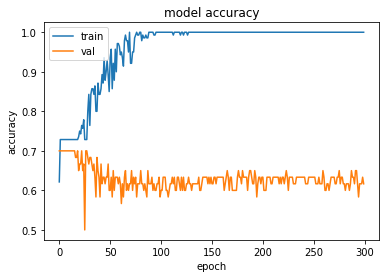

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

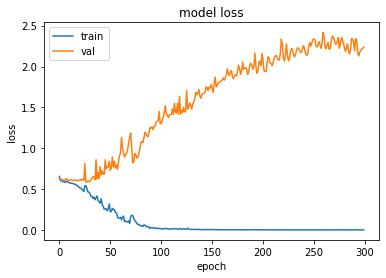

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

---

---

# **Cross-validation**

In [ ]:
number_splits = 3
number_runs   = 3
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))


for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(dataset_images, labels)):

    trainset_x = np.expand_dims(dataset_images[fold_train], axis=3)
    testset_x  = np.expand_dims(dataset_images[fold_test], axis=3)

    model = get_model()
    optimizer = Adam(2e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    print("Training the fold number ", fold_no,"\n")
    history = model.fit(dataset_images, labels, epochs=60)

    scores = model.evaluate(testset_x, labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)




Doing the run number  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 177, 250, 32)      832       
                                                                 
 re_lu (ReLU)                (None, 177, 250, 32)      0         
                                                                 
 dropout (Dropout)           (None, 177, 250, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 89, 125, 128)      102528    
                                                                 
 re_lu_1 (ReLU)              (None, 89, 125, 128)      0         
                                                                 
 dropout_1 (Dropout)         (None, 89, 125, 128)      0         
                                                                 
 conv2d_2 (Conv2D)           

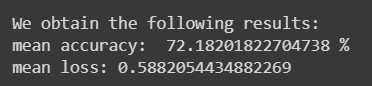

---

---

# **AdaBoost**

In [ ]:
# AdaBootClassifier
ratio = 0.3

delimiter = int(number_file * (1-ratio))

train_data = dataset[:delimiter,:]
test_data  = dataset[delimiter:,:]

train_labels = labels[:delimiter]
test_labels  = labels[delimiter:]

clf = AdaBoostClassifier(n_estimators=100)
clf.fit(train_data, train_labels)

AdaBoostClassifier(n_estimators=100)

In [ ]:
clf.score(test_data, test_labels)

0.65

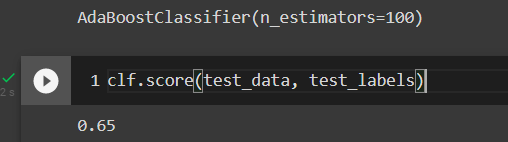

---

---

# **Dense Neural Network**


In [ ]:
# 176400 is too big, averaging and reducing the size and normalizing

print(dataset.shape)
print(dataset.mean())
print(dataset.std())
print("-----------------------")

reducing = 4

dataset_reduce = dataset.reshape((number_file, -1, reducing)).mean(axis=2)
dataset_reduce = preprocessing.normalize(dataset_reduce)


print(dataset_reduce.shape)
print(dataset_reduce.mean())
print(dataset_reduce.std())

(200, 176400)
-37045.87463505839
36137430.23060506
-----------------------
(200, 44100)
-1.864933759798759e-05
0.004761868242996472


In [ ]:
def get_dense_model(dropout_rate=0.3):

  model = tf.keras.Sequential()

  model.add(layers.Dense(3000, input_shape=(44100,)))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(2048))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))


  model.add(layers.Dense(1024))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))


  model.add(layers.Dense(512))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))


  model.add(layers.Dense(256))
  model.add(layers.ReLU())
  model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(1, activation='sigmoid'))

  return model

In [ ]:
model = get_dense_model()

optimizer=Adam(2e-4, beta_1=0.5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 3000)              132303000 
                                                                 
 re_lu_59 (ReLU)             (None, 3000)              0         
                                                                 
 dropout_59 (Dropout)        (None, 3000)              0         
                                                                 
 dense_25 (Dense)            (None, 2048)              6146048   
                                                                 
 re_lu_60 (ReLU)             (None, 2048)              0         
                                                                 
 dropout_60 (Dropout)        (None, 2048)              0         
                                                                 
 dense_26 (Dense)            (None, 1024)            

In [ ]:
ratio = 0.2

delimiter = int(number_file * (1-ratio))

train_data = dataset_reduce[:delimiter,:]
test_data  = dataset_reduce[delimiter:,:]

train_labels = labels[:delimiter]
test_labels  = labels[delimiter:]

history = model.fit(train_data, train_labels, batch_size=100, epochs=10, validation_split=0.2)

Epoch 1/10
2/2 [==============================] - 1s 209ms/step - loss: 0.6927 - binary_accuracy: 0.4609 - val_loss: 0.6869 - val_binary_accuracy: 0.7188
Epoch 2/10
2/2 [==============================] - 0s 67ms/step - loss: 0.6819 - binary_accuracy: 0.7344 - val_loss: 0.6768 - val_binary_accuracy: 0.7188
Epoch 3/10
2/2 [==============================] - 0s 62ms/step - loss: 0.6580 - binary_accuracy: 0.7344 - val_loss: 0.6550 - val_binary_accuracy: 0.7188
Epoch 4/10
2/2 [==============================] - 0s 59ms/step - loss: 0.6060 - binary_accuracy: 0.7344 - val_loss: 0.6186 - val_binary_accuracy: 0.7188
Epoch 5/10
2/2 [==============================] - 0s 58ms/step - loss: 0.4895 - binary_accuracy: 0.7344 - val_loss: 0.5843 - val_binary_accuracy: 0.7188
Epoch 6/10
2/2 [==============================] - 0s 60ms/step - loss: 0.3335 - binary_accuracy: 0.7344 - val_loss: 0.6054 - val_binary_accuracy: 0.7188
Epoch 7/10
2/2 [==============================] - 0s 55ms/step - loss: 0.2610 - b

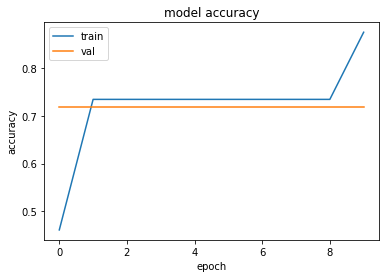

In [ ]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

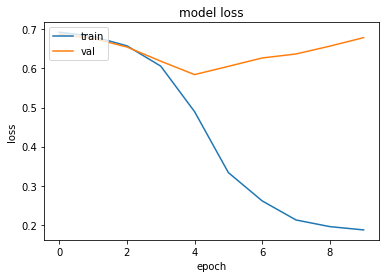

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_data, test_labels)

2/2 [==============================] - 0s 11ms/step - loss: 0.7231 - binary_accuracy: 0.6750


[0.7231346964836121, 0.675000011920929]

---

---

# **Cross-validation Dense Network**

In [ ]:
# we free the memory bc cross validation is memory consumming

del Zxx
del data
del dataset
del dataset_images
del labels
del result
del spectrum
del test_data
del test_labels
del time
del random_data
del dataset_reduce

In [ ]:
number_splits = 3
number_runs   = 3
results_acc   = np.zeros(shape=(number_runs, number_splits))
results_loss  = np.zeros(shape=(number_runs, number_splits))


for run in range(number_runs):
  
  print("\n\n\nDoing the run number ", run+1)
  kfold = KFold(n_splits=number_splits, shuffle=True)

  # K-fold Cross Validation model evaluation
  fold_no = 1

  for split,(fold_train, fold_test) in enumerate(kfold.split(train_data, train_labels)):

    model = get_dense_model()
    optimizer=Adam(2e-4, beta_1=0.5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    print("Training the fold number ", fold_no,"\n")
    history = model.fit(train_data[fold_train], train_labels[fold_train], epochs=10, batch_size=100)

    scores = model.evaluate(train_data[fold_test], train_labels[fold_test], verbose=0)
    print("For the fold number ",  fold_no, ":\nloss = ", scores[0], "\naccuracy = ", scores[1]*100,"%")
    results_acc[run][split] = scores[1] * 100
    results_loss[run][split] = scores[0]

    # Increase fold number
    fold_no = fold_no + 1


results_acc = np.mean(results_acc, axis=1)
results_loss = np.mean(results_loss, axis=1)

results_acc = np.mean(results_acc)
results_loss = np.mean(results_loss)

print("\n\n\nWe obtain the following results:\nmean accuracy: ",results_acc,"%", "\nmean loss:",results_loss)




Doing the run number  1
Training the fold number  1 

Epoch 1/10
2/2 [==============================] - 3s 47ms/step - loss: 0.6924 - binary_accuracy: 0.5188
Epoch 2/10
2/2 [==============================] - 0s 57ms/step - loss: 0.6807 - binary_accuracy: 0.7594
Epoch 3/10
2/2 [==============================] - 0s 45ms/step - loss: 0.6540 - binary_accuracy: 0.7594
Epoch 4/10
2/2 [==============================] - 0s 47ms/step - loss: 0.5810 - binary_accuracy: 0.7594
Epoch 5/10
2/2 [==============================] - 0s 38ms/step - loss: 0.4436 - binary_accuracy: 0.7594
Epoch 6/10
2/2 [==============================] - 0s 47ms/step - loss: 0.3013 - binary_accuracy: 0.7594
Epoch 7/10
2/2 [==============================] - 0s 39ms/step - loss: 0.2279 - binary_accuracy: 0.7594
Epoch 8/10
2/2 [==============================] - 0s 45ms/step - loss: 0.1919 - binary_accuracy: 0.7594
Epoch 9/10
2/2 [==============================] - 0s 58ms/step - loss: 0.1770 - binary_accuracy: 0.7594
Epoch 1

**Results of the cross validation on the dense neural network**

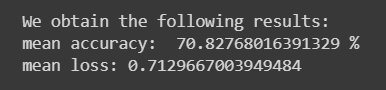